# Deep Learning with Lesion Data Notebook

### Library load
In this notebook we will do deep learning on MRI-derived patient lesion stroke data to predict a subjects performance on a variety of neurological tests on abilities such as memory and intelligence. We choose to use Keras as a front-end for our deep learning models, with back-end being Theano. We also use a lot of scikit wrappers for automating cross-validation and performance evaluation.

Below, begin by loading in the packages required for our deep learning protocol. 

In [3]:
%matplotlib inline
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

seed = 42
np.random.seed(seed)  # for reproducibility

In [4]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda0,floatX=float32"
os.environ["KERAS_BACKEND"] = "theano"
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor


### Load phenotype data for each subject

In [5]:
# zero-pad some of the entries so they match the filenames
df = pd.read_csv('C:/Users/Leo/Documents/GradSchool/2018_IA_Hackathon/data/phenotype/phenotype_t1.csv',
                converters={'ID': lambda x: str(x).zfill(4)})
# make the ID the index in the pandas dataframe
df.set_index('ID', inplace=True)
df.head()

,Gc,Gv,Gl,Gs
ID,,,,
1105,1.023653,0.991524,0.462879,0.511900
1125,-0.223765,-1.001832,-1.862046,-0.327059
1130,-1.127033,-1.870645,-0.899005,-2.209004
1362,-0.063546,0.850259,0.470841,0.756666
1381,0.450993,0.810722,0.667942,0.606078


### Load lesion mask data, t1-weighted MRI data, and combine into single object

In [9]:
# load lesion mask data
data = list()
i=1
labels = []
pheno = []
lesion_masks = glob('C:/Users/Leo/Documents/GradSchool/2018_IA_Hackathon/data/Hackathon_Lesion_Data/LESYMAP_trainingSet/*.nii.gz')
for les_file in lesion_masks:
    match = re.match(r'.*\\([0-9]{4}).nii.gz', les_file)
    sub_id = match.groups()[0]
    if sub_id in df.index:   
        pheno.append(df.loc[sub_id]['Gc'])
        labels.append(sub_id)
        les_img = nib.load(les_file)
        les_img_resamp = resample_to_output(les_img, voxel_sizes=(5, 5, 5))
        les_data = les_img_resamp.get_data()
        data.append(les_data)

In [8]:
# load normalized t1-weighted MRI data
t1 = np.load('C:/Users/Leo/Documents/GradSchool/2018_IA_Hackathon/data/Hackathon_Lesion_Data/lesion_normalized/t1_hnorm.npy')
t1 = [resample_to_output(nib.Nifti1Image(i, np.eye(4)),voxel_sizes=(5,5,5)).get_data() for i in t1]

In [10]:
# combine lesion mask and t1 data into one object
label_guide = np.load('C:/Users/Leo/Documents/GradSchool/2018_IA_Hackathon/data/phenotype/t1_labels.npy')
# order check 
#[str(int(x)) for x in label_guide[:,0]] == labels

data_array = np.array(data)
t1_array = np.array(t1)
data_reshape = data_array.reshape((data_array.shape[0], 1, *data_array.shape[1:4]))
t1_reshape = t1_array.reshape((t1_array.shape[0], 1, *t1_array.shape[1:4]))
X = np.append(data_reshape, t1_reshape, axis = 1)
# save input data shape
input_shape = X[0].shape
# Normalize the training labels
Y = pheno / np.linalg.norm(pheno)

### Import required Keras functions and define model

In [11]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Sequential
import matplotlib.pylab as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

![img1](https://www.researchgate.net/profile/Le_Lu/publication/277335071/figure/fig8/AS:294249976352779@1447166069905/The-proposed-CNN-model-architecture-is-composed-of-five-convolutional-layers-with.png)

In [12]:
# define the model
def keras_model():
    model = Sequential()
    model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
    model.add(Convolution3D(32, (5,5,5), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Convolution3D(64, (2,2,2), activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Convolution3D(64, (2,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])
    return model

### Parameter grid search optimization (cross-validated)

In [13]:
# parameter grid search optimization
from sklearn.model_selection import GridSearchCV

param_grid = dict(epochs=[3], batch_size=[1])
estimator = KerasRegressor(build_fn=keras_model, verbose=0)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid)
grid_result = grid.fit(X,Y)

# summarize parameter search results
print("Best params yield MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best params yield MSE: -0.012765 using {'batch_size': 1, 'epochs': 3}
-0.012765 (0.002604) with: {'batch_size': 1, 'epochs': 3}


### Model train

In [14]:
# training param
EPOCHS = grid_result.best_params_['epochs']
BATCH = grid_result.best_params_['batch_size']

estimator = KerasRegressor(build_fn=keras_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
# cross-validation
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
y_pred = cross_val_predict(estimator, X, Y, cv=kfold)

### Results plot

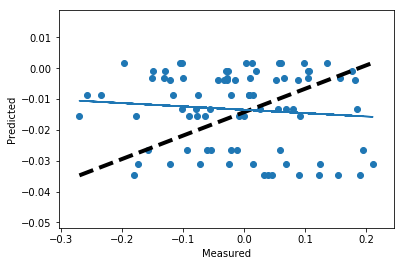

In [24]:
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(Y,y_pred, 1)

fig, ax = plt.subplots()
ax.scatter(Y, y_pred)
ax.plot([Y.min(), Y.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
plt.plot(Y,b+m*Y,'-')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()